# 1.Preproccesing data

Data is extracted using VK API. My profile is https://vk.com/anubo2.

In [159]:
import json
import requests
import vk_api
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
from collections import Counter, defaultdict
from scipy.stats import ks_2samp
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.csgraph import reverse_cuthill_mckee
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from IPython.display import clear_output
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score

In [160]:
vk = vk_api.VkApi(token='token')

Download my friends and friends of my friends and constact my ego graph. To do it, i use vk method friends.get. You can obtain more information about this methods from https://vk.com/dev/friends.get.
This graph does'nt include information about me.

In [245]:
G = nx.Graph()
my_friends = vk.method('friends.get')['items']
for friend in my_friends:
    try:
        get_friend = vk.method('friends.get',{'user_id' : friend})['items']
    except:
        continue
    edges = [(friend, v) for v in get_friend if v in set(my_friends)]
    G.add_edges_from(edges)


Download information, about my friends. To do it, i use vk method users.get. You can obtain more information about this methods from https://vk.com/dev/users.get.

In [246]:
all_friends = [str(node) for node in G.nodes]
friends_info = vk.method('users.get',{'user_ids': ','.join(all_friends), 
                                      'fields' : 'sex,city,schools,personal,universities'})

pars_info = []
for info in friends_info:
        
    city = info.get('city')
    if city:
        city = city['title']
        
    schools = info.get('schools')
    
    if schools:
        schools = schools[0]['name']
    if schools == []:
        schools = np.nan
        
    universties = info.get('universities')
    try:
        universties = universties[0]['name']
    except:
        universties = np.nan
        
    personal_info = info.get('personal')
    if personal_info:
        alcohol = personal_info.get('alcohol') 
        life_main = personal_info.get('life_main') 
        people_main = personal_info.get('people_main') 
        smoking = personal_info.get('smoking')
    else:
        alcohol, life_main, people_main, smoking = [np.nan]*4
    
    alcohol = alcohol if alcohol else np.nan
    life_main = life_main if life_main else np.nan
    people_main = people_main if people_main else np.nan
    smoking = smoking if smoking else np.nan
        
    pars_info.append({'id' : info['id'],
                    'name' : info['first_name'] +' '+ info['last_name'],
                     'sex' : info['sex'],
                     'city' : city,
                     'universities' : universties,
                     'alchohol' : alcohol,
                     'life_main' : life_main,
                     'people_main' : people_main,
                     'smoking' : smoking,
                     'schools' : schools})

Preproccesing data

In [247]:
sex = {1 : "female", 2 : "male", 0 : "not specified"}
people_main = {1 : "intellect and creativity", 2 : "kindness and honesty", 3 : "health and beauty",
               4 : "wealth and power", 5 : "courage and persistance", 6 : "humor and love for life", 
               0 : "not specified", '-1' : 'NONE'}
life_main = {1 : "family and children", 2 : "career and money", 3 : "entertainment and leisure",
             4 : "science and research", 5 : "improving the world", 6 : "personal development",
             7 : "beauty and art", 8 : "fame and influence", 0 : "not specified", '-1' : 'NONE'}
smoking = {1 : "very negative", 2 : "negative", 3 : "neutral", 
           4 : "compromisable", 5 : "positive", 0 : "not specified", '-1' : 'NONE'} 
alchohol = {1 : "very negative", 2 : "negative", 3 : "neutral", 
            4 : "compromisable", 5 : "positive", 0 : "not specified", '-1' : 'NONE'} 

In [248]:
all_attr = {'sex' : sex,
           'people_main' : people_main,
           'life_main' : life_main,
           'smoking' : smoking,
           'alchohol' : alchohol}

In [249]:
data = pd.DataFrame(pars_info)

In [250]:
data.head()

,id,name,sex,city,universities,alchohol,life_main,people_main,smoking,schools
0,8425964,Фёдор Гара,2,None,НИУ ВШЭ (ГУ-ВШЭ),NaN,5.0,6.0,4.0,NaN
1,139495996,Катерина Ложенко,1,Москва,РУДН,NaN,NaN,5.0,NaN,Лицей № 654
2,15027108,Антон Алышев,2,Москва,РУДН,4.0,3.0,6.0,3.0,Школа № 1411
3,26813179,Леон Луканин,2,Tokyo,NaN,NaN,NaN,NaN,NaN,None
4,37839738,Илья Филатов,2,Москва,NaN,NaN,NaN,NaN,NaN,None


In [251]:
data = data.fillna('-1')

In [252]:
for key in all_attr:
    data[key] = data[key].map(all_attr[key])

In [253]:
data.head(10)

,id,name,sex,city,universities,alchohol,life_main,people_main,smoking,schools
0,8425964,Фёдор Гара,male,-1,НИУ ВШЭ (ГУ-ВШЭ),NONE,improving the world,humor and love for life,compromisable,-1
1,139495996,Катерина Ложенко,female,Москва,РУДН,NONE,NONE,courage and persistance,NONE,Лицей № 654
2,15027108,Антон Алышев,male,Москва,РУДН,compromisable,entertainment and leisure,humor and love for life,neutral,Школа № 1411
3,26813179,Леон Луканин,male,Tokyo,-1,NONE,NONE,NONE,NONE,-1
4,37839738,Илья Филатов,male,Москва,-1,NONE,NONE,NONE,NONE,-1
5,38846959,Максим Новосельцев,male,Москва,РУДН,NONE,NONE,NONE,NONE,Лицей №1 им. Н. К. Крупской
6,58061631,Артём Асташев,male,Москва,-1,neutral,entertainment and leisure,humor and love for life,very negative,Школа № 17
7,77231871,Артём Ерёменко,male,Краснодар,РУДН,NONE,entertainment and leisure,humor and love for life,NONE,Гимназия № 23
8,78220135,Лиза Чернышова,female,Москва,МГУ,NONE,personal development,humor and love for life,negative,Школа № 281
9,83924161,Настя Захарчук,female,Москва,РУДН,NONE,NONE,NONE,NONE,Школа №12


Relabel nodes in the graph

In [254]:
map_to_relabel = {Id : name for Id, name in data[['id','name']].values}

In [255]:
G = nx.relabel_nodes(G, map_to_relabel)

Analyze information of friends

In [172]:
data['city'].value_counts()/data.shape[0]

Москва             0.407895
-1                 0.289474
Кашира             0.171053
Ступино            0.013158
Домодедово         0.013158
Tokyo              0.013158
Мурманск           0.013158
Краснодар          0.013158
Одинцово           0.013158
Лобня              0.013158
Санкт-Петербург    0.013158
Фрязино            0.013158
Исфара             0.013158
Name: city, dtype: float64

A lot of my friends from Moscow. It is becouse, They are friends  from bachelor or friends from Kashira, who moved in Moscow. The second part of my friends from Kashira, it is placed, where i lived. Also, there are friends from another city. It is also friend from Bachelor, who don't change information about city.

In [173]:
data['sex'].value_counts()/data.shape[0]

male      0.671053
female    0.328947
Name: sex, dtype: float64

The most part of my friend is male (about 67%).

In [174]:
data['universities'].value_counts()/data.shape[0]

-1                                                                              0.552632
РУДН                                                                            0.250000
РГСУ                                                                            0.013158
МГТУ ГА                                                                         0.013158
НИУ ВШЭ (ГУ-ВШЭ)                                                                0.013158
МГТУ «Станкин»                                                                  0.013158
РТУ МИРЭА                                                                       0.013158
МГУПИ (КФ)                                                                      0.013158
Catholic Theological Union                                                      0.013158
Институт бизнеса и дизайна (бывш. ИнОБО)                                        0.013158
МГОУ им. Черномырдина (ныне в сост. МАМИ) (бывш. ВЗПИ)                          0.013158
МГУ                  

The most part of friend do not filled information about university. We can see, that a lot of my friends from RUDN, it is my friends from bachelor. Anoter people it is friends from Kashira, who moved to Moscow or friends, who incorrectly filled information about university. 

In [175]:
data['alchohol'].value_counts()/data.shape[0]

NONE             0.842105
compromisable    0.078947
very negative    0.039474
neutral          0.026316
negative         0.013158
Name: alchohol, dtype: float64

A lot of friends don't filed this information (about 84%). So, we can drop this attribute.

In [176]:
data['life_main'].value_counts()/data.shape[0]

NONE                         0.763158
personal development         0.092105
entertainment and leisure    0.065789
improving the world          0.026316
beauty and art               0.013158
family and children          0.013158
fame and influence           0.013158
science and research         0.013158
Name: life_main, dtype: float64

A lot of friends don't filed this information (about 76 %). So, we can drop this attribute.

In [177]:
data['people_main'].value_counts()/data.shape[0]

NONE                        0.710526
humor and love for life     0.118421
intellect and creativity    0.078947
kindness and honesty        0.065789
wealth and power            0.013158
courage and persistance     0.013158
Name: people_main, dtype: float64

A lot of friends don't filed this information (about 71%). So, we can drop this attribute.

In [178]:
data['smoking'].value_counts()/data.shape[0]

NONE             0.723684
compromisable    0.105263
very negative    0.078947
negative         0.065789
neutral          0.026316
Name: smoking, dtype: float64

A lot of friends don't filed this information (about 72%). So, we can drop this attribute.

In [179]:
data['schools'].value_counts()/data.shape[0]

-1                                                 0.473684
Школа № 4                                          0.171053
Школа № 7                                          0.039474
Школа № 17                                         0.026316
Школа № 875                                        0.013158
Гимназия №1531 (бывш. шк. 21 специальная, 1217)    0.013158
Инженерная школа № 1581 (при МГТУ им. Баумана)     0.013158
Школа №1                                           0.013158
SAE Institute                                      0.013158
Школа № 2063 (бывш. шк. 1)                         0.013158
Школа №4                                           0.013158
Школа № 2007                                       0.013158
Лицей № 3                                          0.013158
Лицей № 97                                         0.013158
Школа №15                                          0.013158
Лицей №1 им. Н. К. Крупской                        0.013158
Школа № 1411                            

The most part of my friends are from Kashira schools (№ 4 and  № 7)

Drop not informative attribute

In [256]:
for name in ['alchohol', 'life_main', 'people_main', 'smoking']:
    data.drop(name, axis=1, inplace=True)

In [257]:
def make_dict(name):
    return {n : v for n,v in data[['name',name]].values}

for name in ['sex', 'city', 'universities', 'schools']:
    dict_to_atr = make_dict(name)
    nx.set_node_attributes(G, dict_to_atr, name)

Draw network

In [260]:
nx.write_gexf(G, 'MyNetwork.gexf')

In [261]:
G = nx.read_gexf('MyNetwork.gexf')

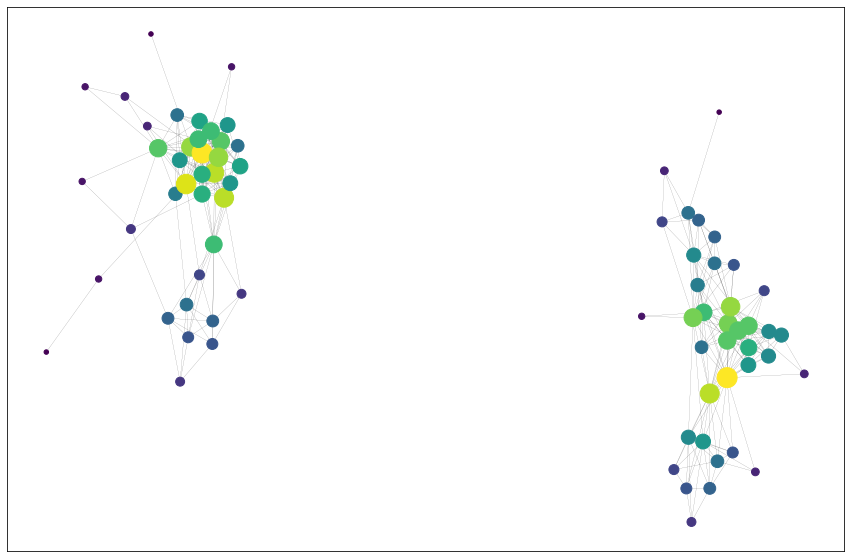

In [262]:
node_size = [deg*20 for _,deg in nx.degree(G)]
node_color = [deg for _, deg in nx.degree(G)]
plt.figure(figsize=(15, 10))
nx.draw_networkx(G, node_size=node_size, node_color=node_color, with_labels=False, width=0.1)
plt.savefig('MyNetwork.png')

My ego network contain 2 connected components. First component is friends from Kashira. Second component is friends from bachelor (Moscow).

In [183]:
print('Size of graph', len(G.nodes))
print('Order of graph', len(G.edges))

Size of graph 75
Order of graph 349


In [184]:
print('Average clustering coefficient', nx.average_clustering(G))

Average clustering coefficient 0.6238800938769978


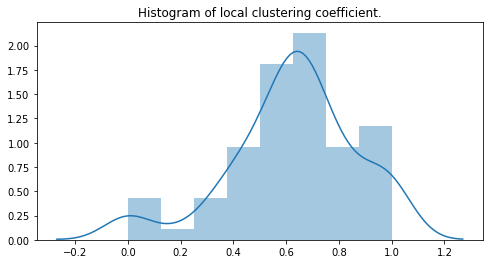

In [185]:
#clustering coefficient
clustering_coef = nx.clustering(G)
clustering_coef = [coef for _,coef in clustering_coef.items()]
plt.figure(figsize = (8,4))
sns.distplot(clustering_coef)
plt.title('Histogram of local clustering coefficient.')
plt.savefig('Histogram of local clustering coefficient.png')

Average clustering coefficient of my network is high. Also, a lot of my friends have high local clustering coefficient. So, my network contain some communities.

In [186]:
components = list(nx.algorithms.components.connected_components(G))
print('Number of connected components', len(components))
print('Size of connected components')
components.sort(key = lambda x: len(x))
for ind, comm in enumerate(components):
    print('Num component', ind, 'Size', len(comm))

Number of connected components 2
Size of connected components
Num component 0 Size 37
Num component 1 Size 38


We will analyze the largest components (friends from Kashira).

In [187]:
G = nx.subgraph(G, components[-1])

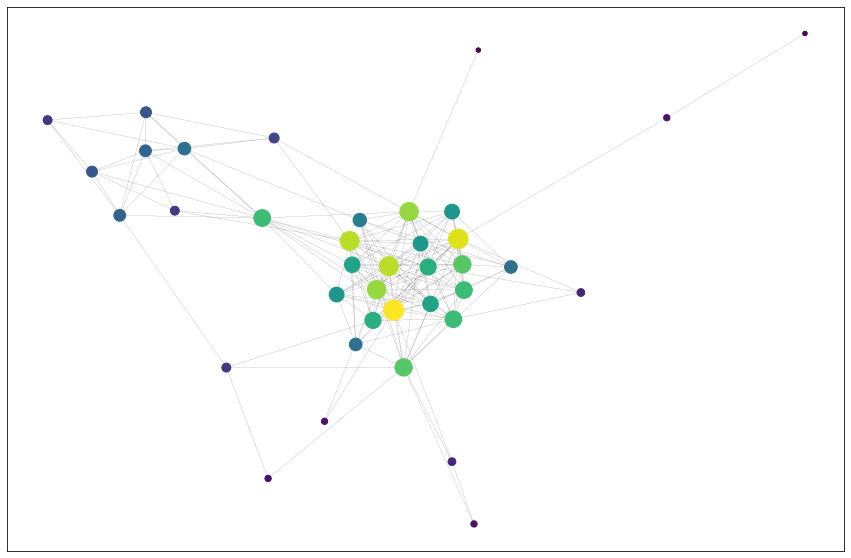

In [188]:
node_size = [deg*20 for _,deg in nx.degree(G)]
node_color = [deg for _, deg in nx.degree(G)]
plt.figure(figsize=(15, 10))
nx.draw_networkx(G, node_size=node_size, node_color=node_color, with_labels=False, width=0.1)
plt.savefig('largest comp.png')

In [189]:
print('Average shortest path length', nx.average_shortest_path_length(G))
print('Radius', nx.radius(G))
print('Diameter', nx.diameter(G))

Average shortest path length 2.1038406827880514
Radius 3
Diameter 5


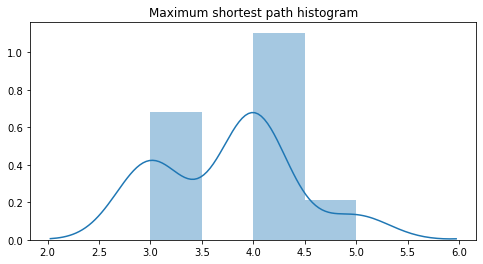

In [190]:
maximum_short_path = []
for _, val in nx.shortest_path_length(G):
    maximum_short_path.append(max([v for _,v in val.items()]))
    
plt.figure(figsize = (8,4))
sns.distplot(maximum_short_path)
plt.title('Maximum shortest path histogram')
plt.savefig('Maximum shortest path histogram.png')

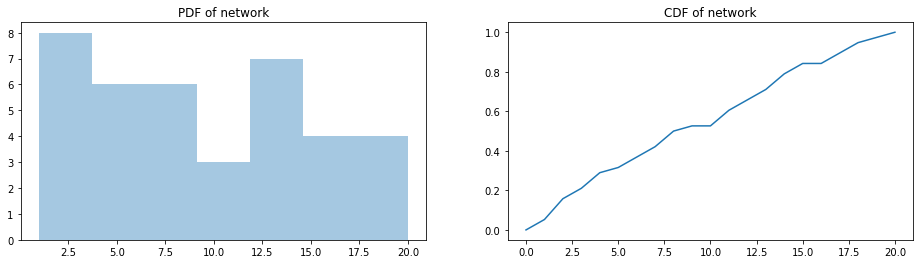

In [191]:
deg_seq = np.array([deg for _, deg in nx.degree(G)])
pdf = np.zeros(max(deg_seq)+1)
C = Counter(deg_seq)
for ind, val in C.items():
    pdf[ind] = val/deg_seq.shape[0]
cdf = np.cumsum(pdf)

fig = plt.figure(figsize = (16,4))
plt.subplot(1,2,1)
sns.distplot(deg_seq, bins=7, kde=False)
plt.title("PDF of network")
plt.subplot(1,2,2)
plt.plot(cdf)
plt.title('CDF of network')
plt.savefig('PDF.png')

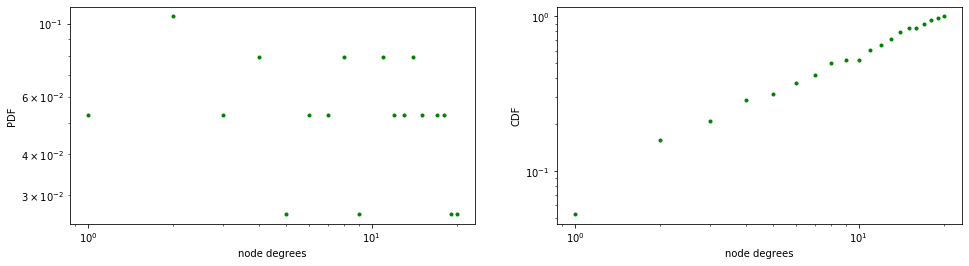

<Figure size 432x288 with 0 Axes>

In [192]:
# in log log scale
plt.figure(figsize=(16,4))   
plt.subplot(1,2,1)
plt.loglog(np.arange(0, len(pdf)), pdf, 'g.')
plt.xlabel('node degrees')
plt.ylabel('PDF')
        
plt.subplot(1,2,2)
plt.loglog(np.arange(0, len(cdf)), cdf, 'g.')
plt.xlabel('node degrees')
plt.ylabel('CDF')
plt.show()
plt.savefig('LogPDF.png')

The distribution of degree is similar to binomial.

In [193]:
def power_law_cdf(x, alpha=3.5, x_min=1):
    return 1 - x**(-alpha+1)/x_min**(-alpha+1)

In [194]:
def mle_power_law_params(degree_sequence):
    from scipy.stats import kstest
    
    best_score = float('inf')
    for x_min in range(int(degree_sequence.min()),int(degree_sequence.max()),1):
        new_degree_sequence = degree_sequence[degree_sequence >= x_min]
        n = new_degree_sequence.shape[0]
        alpha = 1 + n*(1/sum(np.log(new_degree_sequence/x_min)))
        test = kstest(new_degree_sequence, lambda x : power_law_cdf(x,alpha,x_min))[0]
        #print(x_min, alpha,round(test,4))
        if(test < best_score):
            best_param = [alpha,x_min]
            best_score = test 
    #print(best_param)
    return best_score, best_param

best_score, hat_param = mle_power_law_params(deg_seq)
hat_alpha, hat_x_min = hat_param
print('Best score', best_score)
print('alpha', hat_alpha)
print('x_min', hat_x_min)

Best score 0.20237459217141035
alpha 4.709889318041299
x_min 11


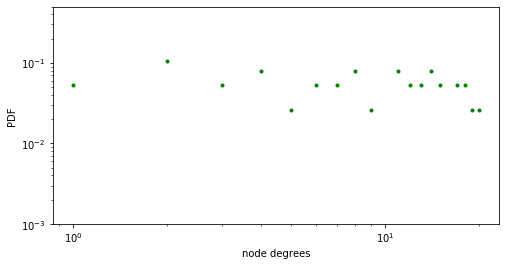

In [195]:
def power_law_pdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return C * x ** (-alpha)

plt.figure(figsize=(8,4))   
plt.loglog(np.arange(0, len(pdf)), pdf, 'g.')
plt.xlabel('node degrees')
plt.ylabel('PDF')

hat_alpha, hat_x_min = mle_power_law_params(deg_seq)
x_space = np.linspace(hat_x_min, deg_seq.max(), 50)
plt.plot(x_space, power_law_pdf(x_space, hat_alpha, hat_x_min), 
         label='Estimated PDF', c='tab:orange')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.001, 0.5);

Compare our network with different model.

In [196]:
size = len(G.nodes)
order = len(G.edges)
mean_degree = deg_seq.mean()
N = 10
result = []

def select_gygantic_component(g: nx.Graph) -> nx.Graph:
    components = list(nx.connected_components(g))
    components.sort(key = lambda x : len(x))
    return g.subgraph(components[-1])

def generate_graph(name):
    if name == 'Barabasi-Albert':
        return nx.barabasi_albert_graph(size, int(order/size))
    if name == 'Watts-Strogatz':
        return nx.watts_strogatz_graph(size, int(mean_degree), 0.5)
    return nx.erdos_renyi_graph(size, mean_degree/(size-1))

for model in ['Barabasi-Albert', 'Watts-Strogatz', 'Erdos-Renyi']:
    dict_stats = {name : 0 for name in ['Average shortest path',
                                    'Average clustering coefficient',
                                    'radius','diameter','ks_test']}
    for _ in range(N):
        new_G = generate_graph(model)
        new_deg_seq = [deg for _,deg in nx.degree(new_G)]
        large_cc = select_gygantic_component(new_G)
        radius = nx.radius(large_cc)
        diameter = nx.diameter(large_cc)
        avg_path = nx.average_shortest_path_length(large_cc)
        avg_clust = nx.average_clustering(new_G)
        ks_test = ks_2samp(deg_seq, new_deg_seq)[0]
        dict_stats['radius'] += radius
        dict_stats['diameter'] += diameter
        dict_stats['Average shortest path'] += avg_path
        dict_stats['Average clustering coefficient'] += avg_clust
        dict_stats['ks_test'] += ks_test
    for key in dict_stats.keys():
        dict_stats[key]/=N
        
    result.append(dict_stats)
    

In [197]:
result.append({'radius':nx.radius(G),
              'diameter':nx.diameter(G),
              'Average shortest path':nx.average_shortest_path_length(G),
              'Average clustering coefficient':nx.average_clustering(G),
              'ks_test' : 1})

In [198]:
result = pd.DataFrame(result, index = ['Barabasi-Albert', 'Watts-Strogatz', 'Erdos-Renyi', 'Network'])
result

,Average shortest path,Average clustering coefficient,radius,diameter,ks_test
Barabasi-Albert,1.975676,0.316874,2.0,3.1,0.302632
Watts-Strogatz,1.919203,0.238865,2.3,3.0,0.392105
Erdos-Renyi,1.815505,0.246793,2.0,3.0,0.286842
Network,2.103841,0.604807,3.0,5.0,1.000000


Clonest network model is Erdos-Renyi by Kstest. Barabasi-Albert network is close to my network by Average shortest path and Average clustering coefficient.

In [199]:
p = (np.array(deg_seq).mean())/(len(G.nodes) - 1)
print('Esimated probability', p)

Esimated probability 0.2532005689900427


# Structural Analysis

In [200]:
degree_cent = nx.degree_centrality(G)
closeness_cent = nx.closeness_centrality(G)
betweenness_cent = nx.betweenness_centrality(G)
pagerank = nx.pagerank(G)

In [201]:
data = pd.Series(degree_cent)
data = data.sort_values(ascending = False).head(10)
data

Антон Климов         0.540541
Аня Борисова         0.513514
Павел Прокопьев      0.486486
Александр Косицын    0.486486
Тимур Юсубов         0.459459
Алина Никитина       0.459459
Илья Мишин           0.405405
Герман Павлов        0.405405
Евгений Найденов     0.378378
Настя Флёрова        0.378378
dtype: float64

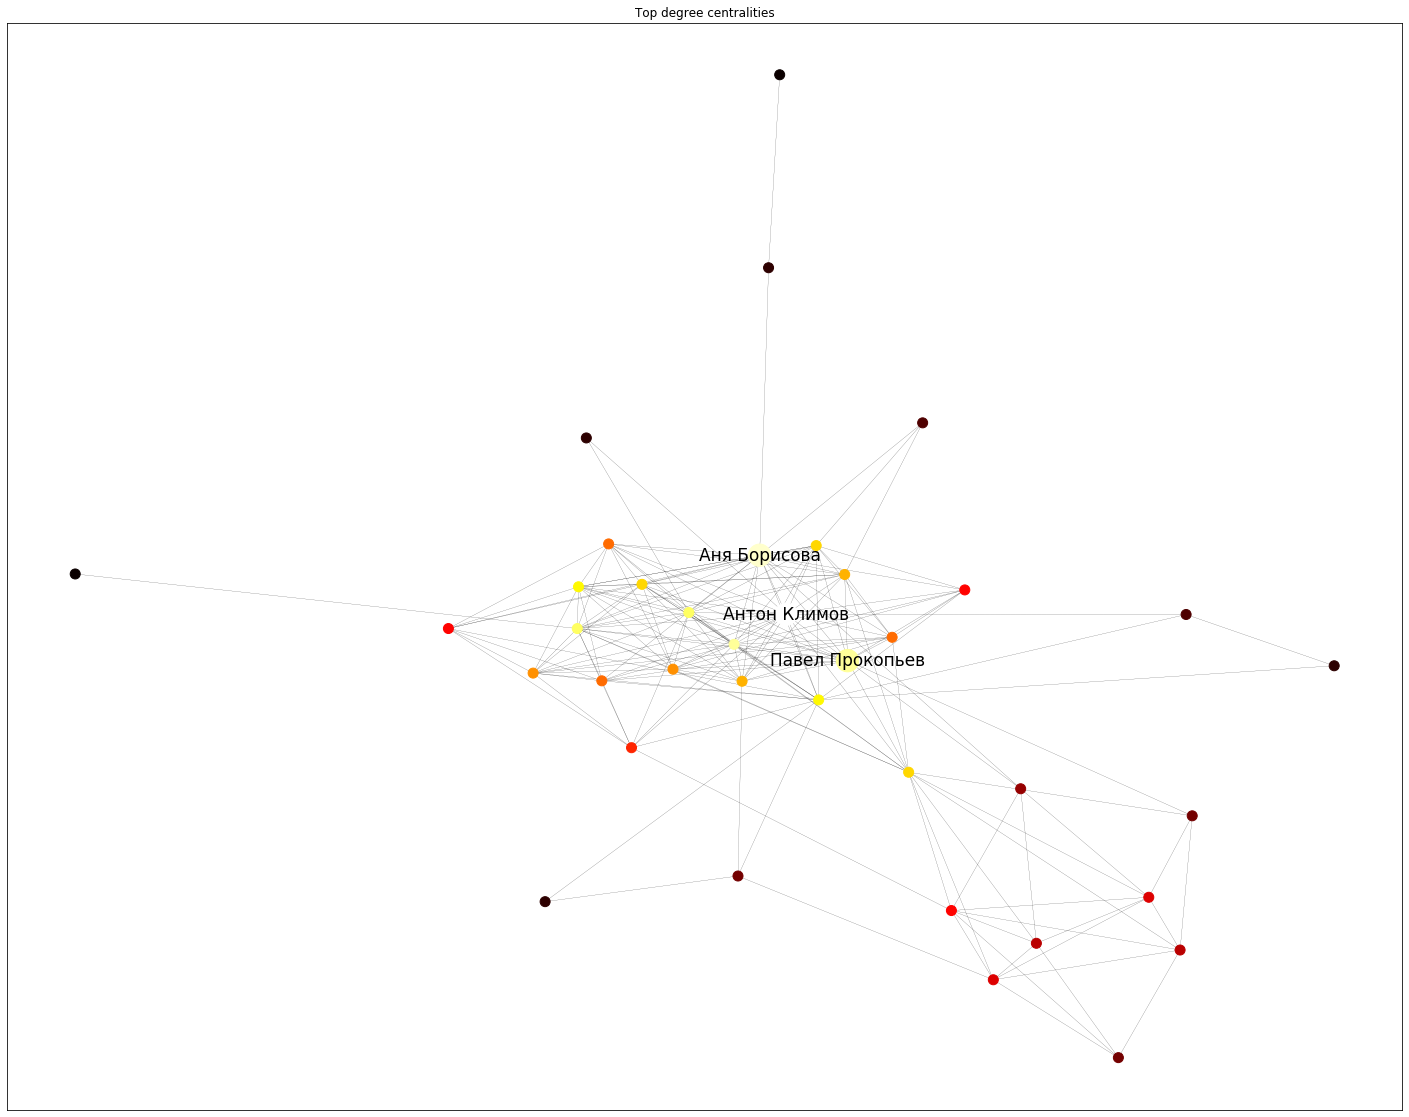

In [202]:
node_size = [deg*20 for _,deg in nx.degree(G)]
label = {i : i for i in data.head(3).index}
cent = np.array([val for _,val in degree_cent.items()])
plt.figure(figsize=(25, 20))
size = [100 if ind not in label else 500 for ind in G.nodes]
nx.draw_networkx(G, 
                width = 0.15,
                node_color = cent*300,
                node_size = size,
                cmap=plt.cm.hot,
                labels =label,
                font_size = 17,
                font_color = 'black')
plt.title('Top degree centralities')
plt.savefig('Top degree centralities.png')

Аня Борисова, Павел Прокопьев, Антон Климов are my classmates from high schools. They went to middle school together. Moreover, they was popular in the schools and they were familiar with many people. Hince, they have high degree centrality.

In [203]:
data = pd.Series(closeness_cent)
data = data.sort_values(ascending = False).head(10)
data

Антон Климов         0.660714
Александр Косицын    0.637931
Аня Борисова         0.637931
Тимур Юсубов         0.627119
Павел Прокопьев      0.616667
Алина Никитина       0.606557
Дима Жмыхов          0.569231
Герман Павлов        0.560606
Евгений Найденов     0.560606
Андрей Шершнёв       0.544118
dtype: float64

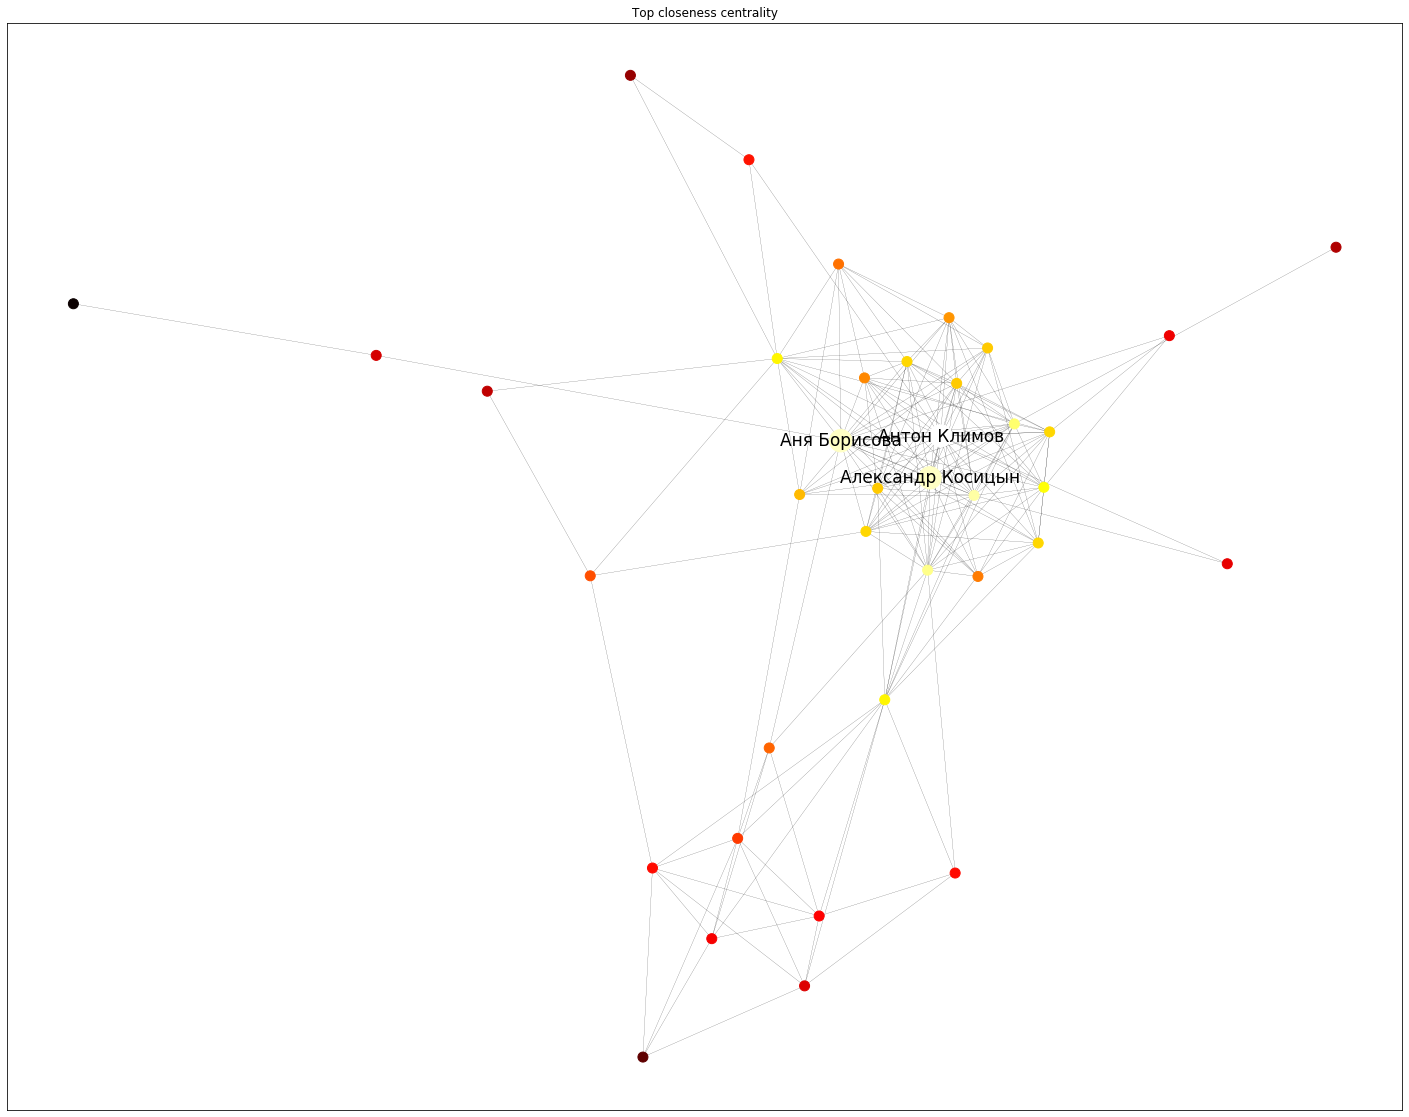

In [204]:
label = {i : i for i in data.head(3).index}
cent = np.array([val for _,val in closeness_cent.items()])
plt.figure(figsize=(25, 20))
size = [100 if ind not in label else 500 for ind in G.nodes]
nx.draw_networkx(G, 
                width = 0.15,
                node_color = cent*300,
                node_size = size,
                cmap=plt.cm.hot,
                labels =label,
                font_size = 17,
                font_color = 'black')
plt.title('Top closeness centrality')
plt.savefig('Top closeness centralities.png')

Аня Борисова, Антон Климов, Александр Косицын went to middle school together. This friends was very popular in the schools.  So, this friends are very close to my different friends from my schools. Morover, Антон Климов, Аня Борисова introduced me to people from another school. Hence, they have high closeness centrality.

In [205]:
data = pd.Series(betweenness_cent)
data = data.sort_values(ascending = False).head(10)
data

Аня Борисова         0.165434
Евгений Найденов     0.162873
Герман Павлов        0.127280
Антон Климов         0.096842
Алина Никитина       0.073126
Павел Прокопьев      0.068402
Алёна Меркулова      0.054054
Тимур Юсубов         0.048339
Евгения Маклагина    0.038457
Никита Хованский     0.035713
dtype: float64

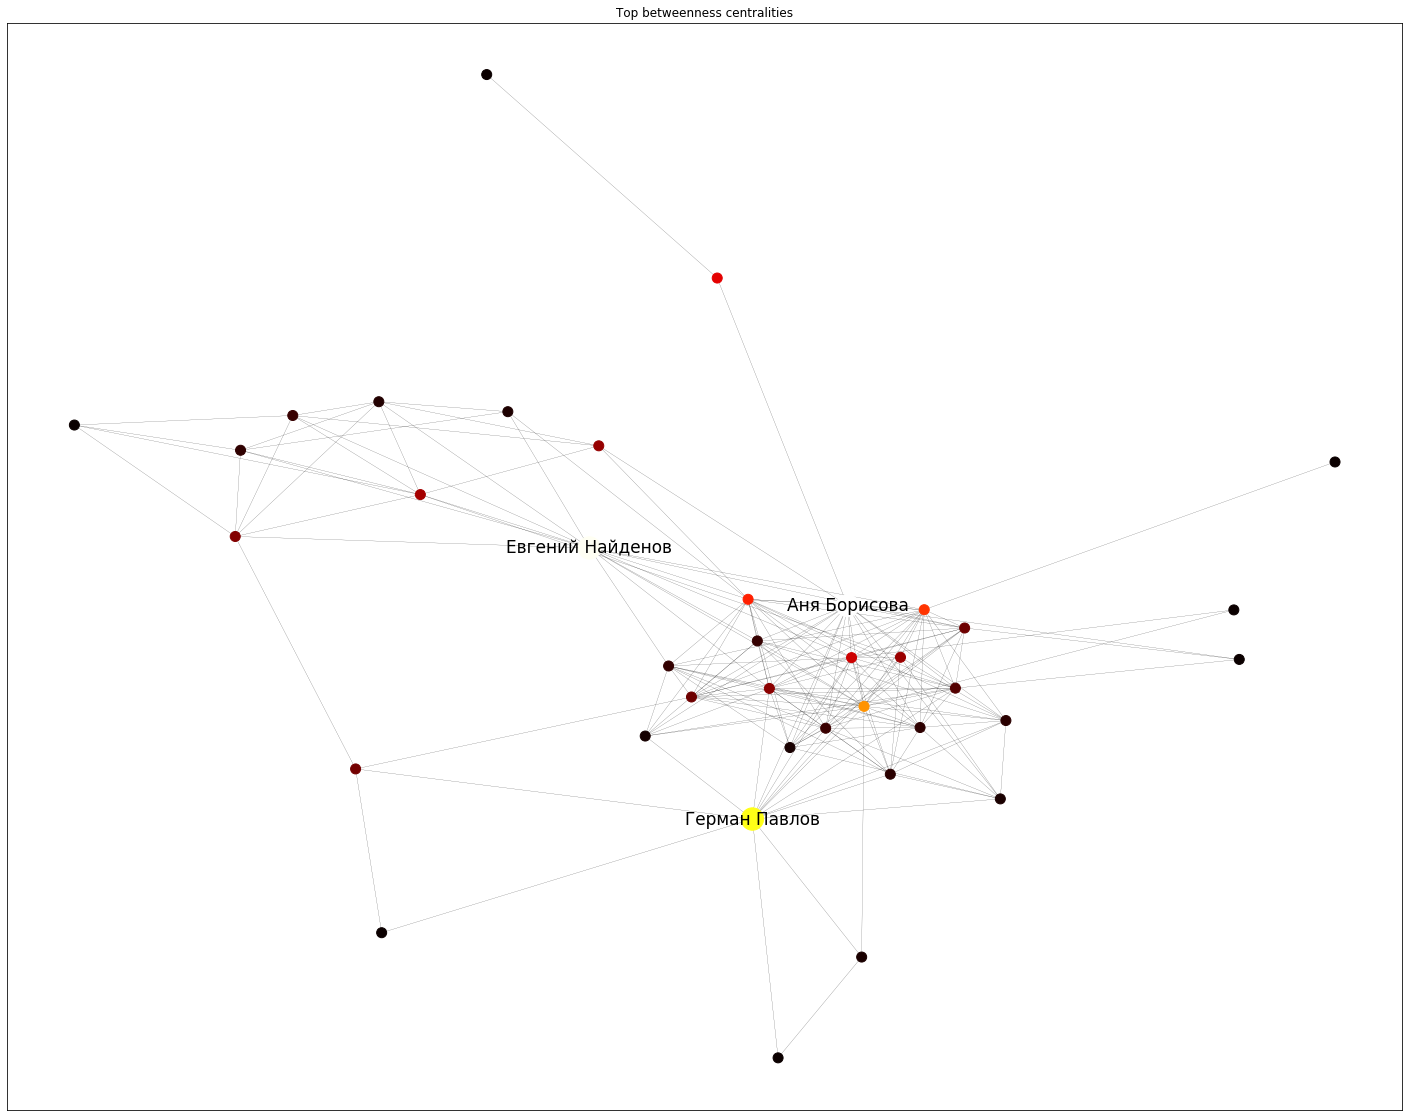

In [206]:
label = {i : i for i in data.head(3).index}
cent = np.array([val for _,val in betweenness_cent.items()])
plt.figure(figsize=(25, 20))
size = [100 if ind not in label else 500 for ind in G.nodes]
nx.draw_networkx(G, 
                width = 0.15,
                node_color = cent*300,
                node_size = size,
                cmap=plt.cm.hot,
                labels =label,
                font_size = 17,
                font_color = 'black')
plt.title('Top betweenness centralities')
plt.savefig('Top betweenness centralities.png')

Аня Борисова is very popular person in my schools. Moreover, she know my friends from another school. So, she know people from various communities. Евгений Найденов is my best friend from middle school and they know all my classmates from middle schools. Герман Павлов is my cousin. After ending middle schools, he went to another city (Stupino). After that, I met some of his new friends from Stupino and add they to vk friends. So, they have high betweenness centralities score.

In [207]:
data = pd.Series(pagerank)
data = data.sort_values(0,ascending = False).head(10)
data

Аня Борисова         0.050607
Антон Климов         0.050100
Павел Прокопьев      0.044243
Алина Никитина       0.043389
Герман Павлов        0.043103
Александр Косицын    0.043038
Тимур Юсубов         0.042017
Евгений Найденов     0.038844
Илья Мишин           0.035951
Настя Флёрова        0.034919
dtype: float64

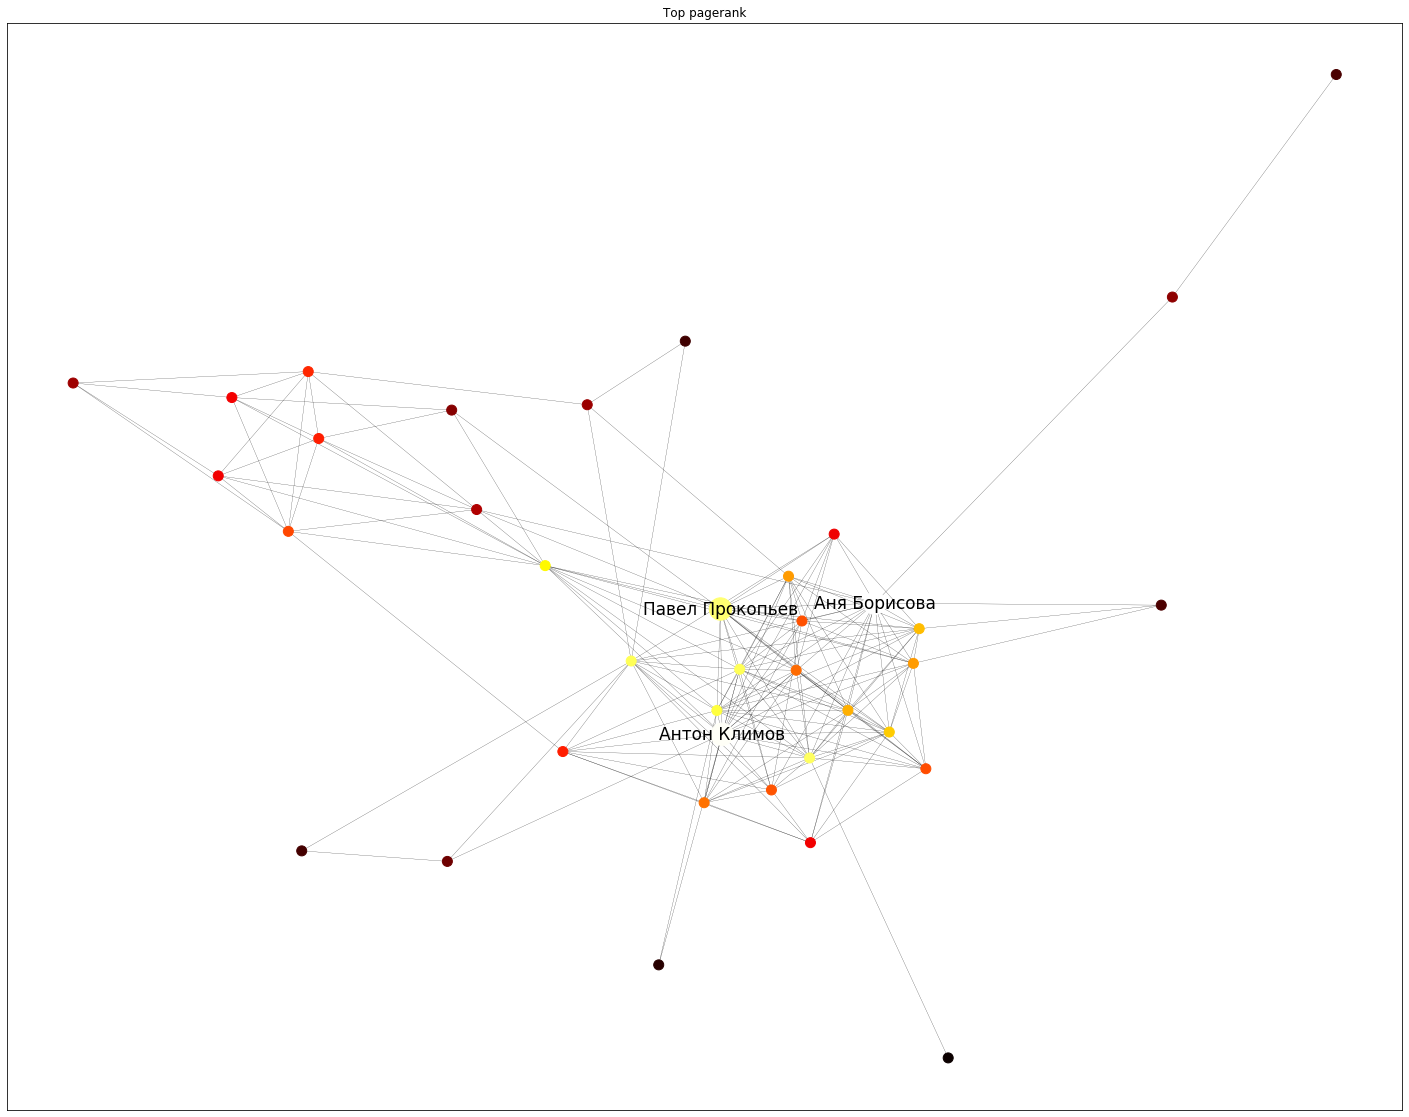

In [208]:
node_size = [deg*20 for _,deg in nx.degree(G)]
label = {i : i for i in data.head(3).index}
cent = np.array([pagerank[ind] for ind in G.nodes])
plt.figure(figsize=(25, 20))
size = [100 if ind not in label else 500 for ind in G.nodes]
nx.draw_networkx(G, 
                width = 0.2,
                node_color = cent*300,
                node_size = size,
                cmap=plt.cm.hot,
                labels =label,
                font_size = 17,
                font_color = 'black')
plt.title('Top pagerank')
plt.savefig('Top pagerank.png')

Аня Борисова, Антон Климов, Павел Прокопьев was very popular in the schools. So, probability of stopping on this page after random walking on ego network is high.

Compare ranking of pagerank and different centralities and plot scatter plot.

In [209]:
def compare_graph(score1, score2, name_score1, name_score2):
    score1_rank = {key : rank for rank,key in enumerate(sorted(score1, key = score1.get, reverse=True))}
    score2_rank = {key : rank for rank,key in enumerate(sorted(score2, key = score2.get, reverse=True))}
    score1_list = [score1_rank[node] for node in G.nodes]
    score2_list = [score2_rank[node] for node in G.nodes]
    plt.scatter(score1_list, score2_list)
    plt.title(
    'Pearson corr coeff: {}'.format( \
    str(round(scipy.stats.stats.pearsonr(score1_list, score2_list)[0],2))))
    plt.xlabel(name_score1)
    plt.ylabel(name_score2)

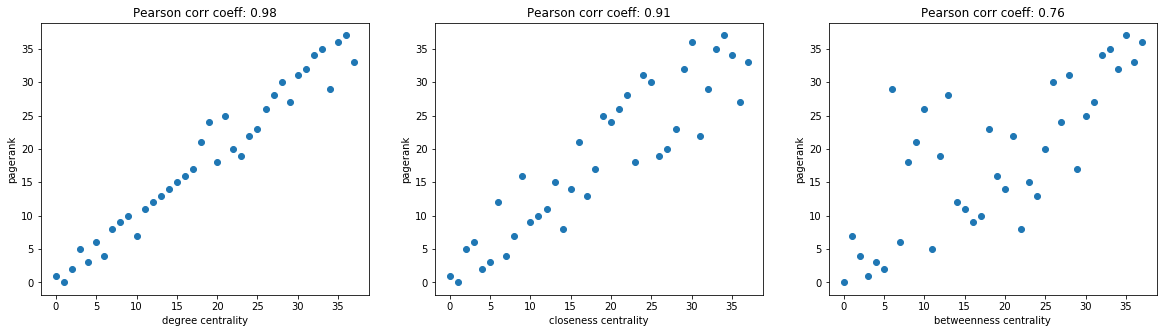

In [210]:
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
compare_graph(degree_cent, pagerank, 'degree centrality', 'pagerank')
plt.subplot(1,3,2)
compare_graph(closeness_cent, pagerank, 'closeness centrality', 'pagerank')
plt.subplot(1,3,3)
compare_graph(betweenness_cent, pagerank, 'betweenness centrality', 'pagerank')
plt.savefig('Compare centrality.png')

 Ranking with pagerank correlates with ranking with different centralities (pearson correlation coefficient is very high).

Make Assortative Mixing according to node attributes (sex, universities, schools)

In [211]:
def genre_mixing(G, attr):
    mixing = nx.attribute_mixing_matrix(G, attr)
    mapping = {g: idx for idx, g in nx.get_node_attributes(G, attr).items()}
    return mixing, mapping

In [214]:
def plot_mixing(attr):
    fig = plt.figure(figsize=(8, 8))
    mixing, mapping = genre_mixing(G, attr)
        
    plt.title(attr)
    hmap = sns.heatmap(
        mixing,
        cbar=False,
        annot=True,
        square=True)
    hmap.set_xticklabels(
        labels=[m for m in mapping], 
        rotation=45, 
        horizontalalignment='right')
    hmap.set_yticklabels(
        labels=[m for m in mapping], 
        rotation=0)
    plt.savefig('Assortative Mixing by ' + attr)
    plt.show()

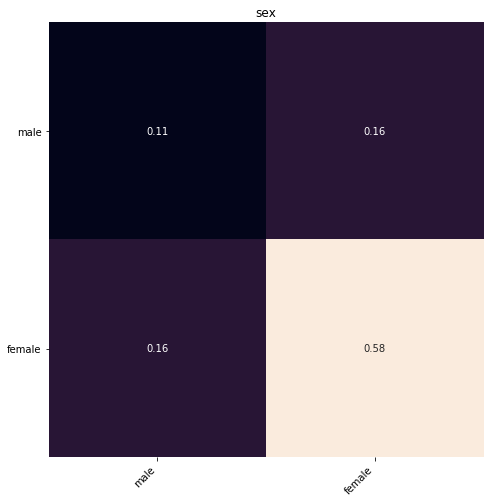

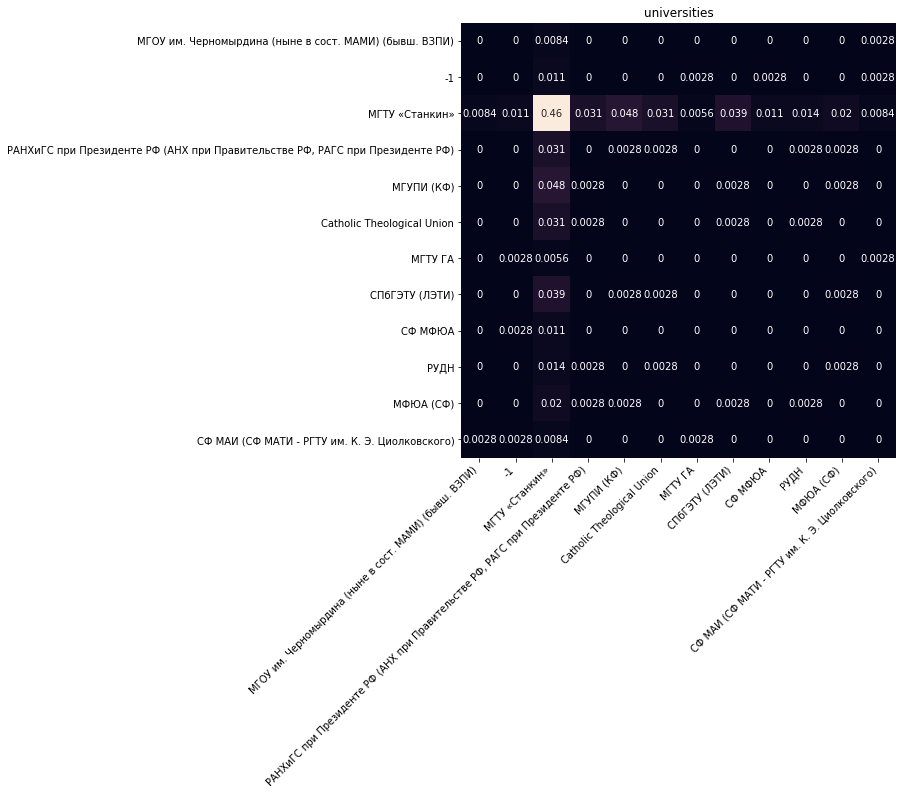

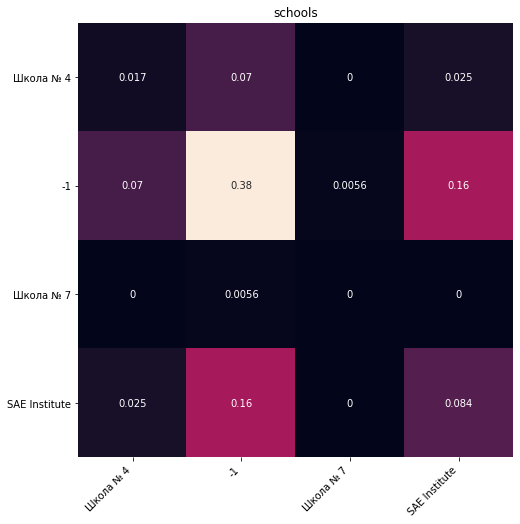

In [218]:
for ind, attr in enumerate(['sex', 'universities', 'schools']):
    plot_mixing(attr)

Female friends are more friends with each other than male, according assortative mixing by sex attribute. A lot of friends from school study at МГТУ 'Станкин'. We can also see, that there are high assortative score between SAE institute. It is because one friend from schools №7 filled incorrect information about schools. Also, there are assortative with SAE institute and None filled information. I think, it is because people who don't want to fill information about schools like to put a random popular school in this field.

Analyze node structural equivalence/similarity

In [219]:
def sim_matrices(G):
    A = nx.to_numpy_array(G)
    p = np.corrcoef(A)
    J = np.zeros(A.shape)
    cos = cosine_similarity(A)
    
    for i, j, c in nx.jaccard_coefficient(nx.from_numpy_array(A)):
        J[i, j] = c
        J[j, i] = c
        
    return A, p, J, cos

def cm_order(G):
    return reverse_cuthill_mckee(csr_matrix(nx.to_numpy_array(G)))

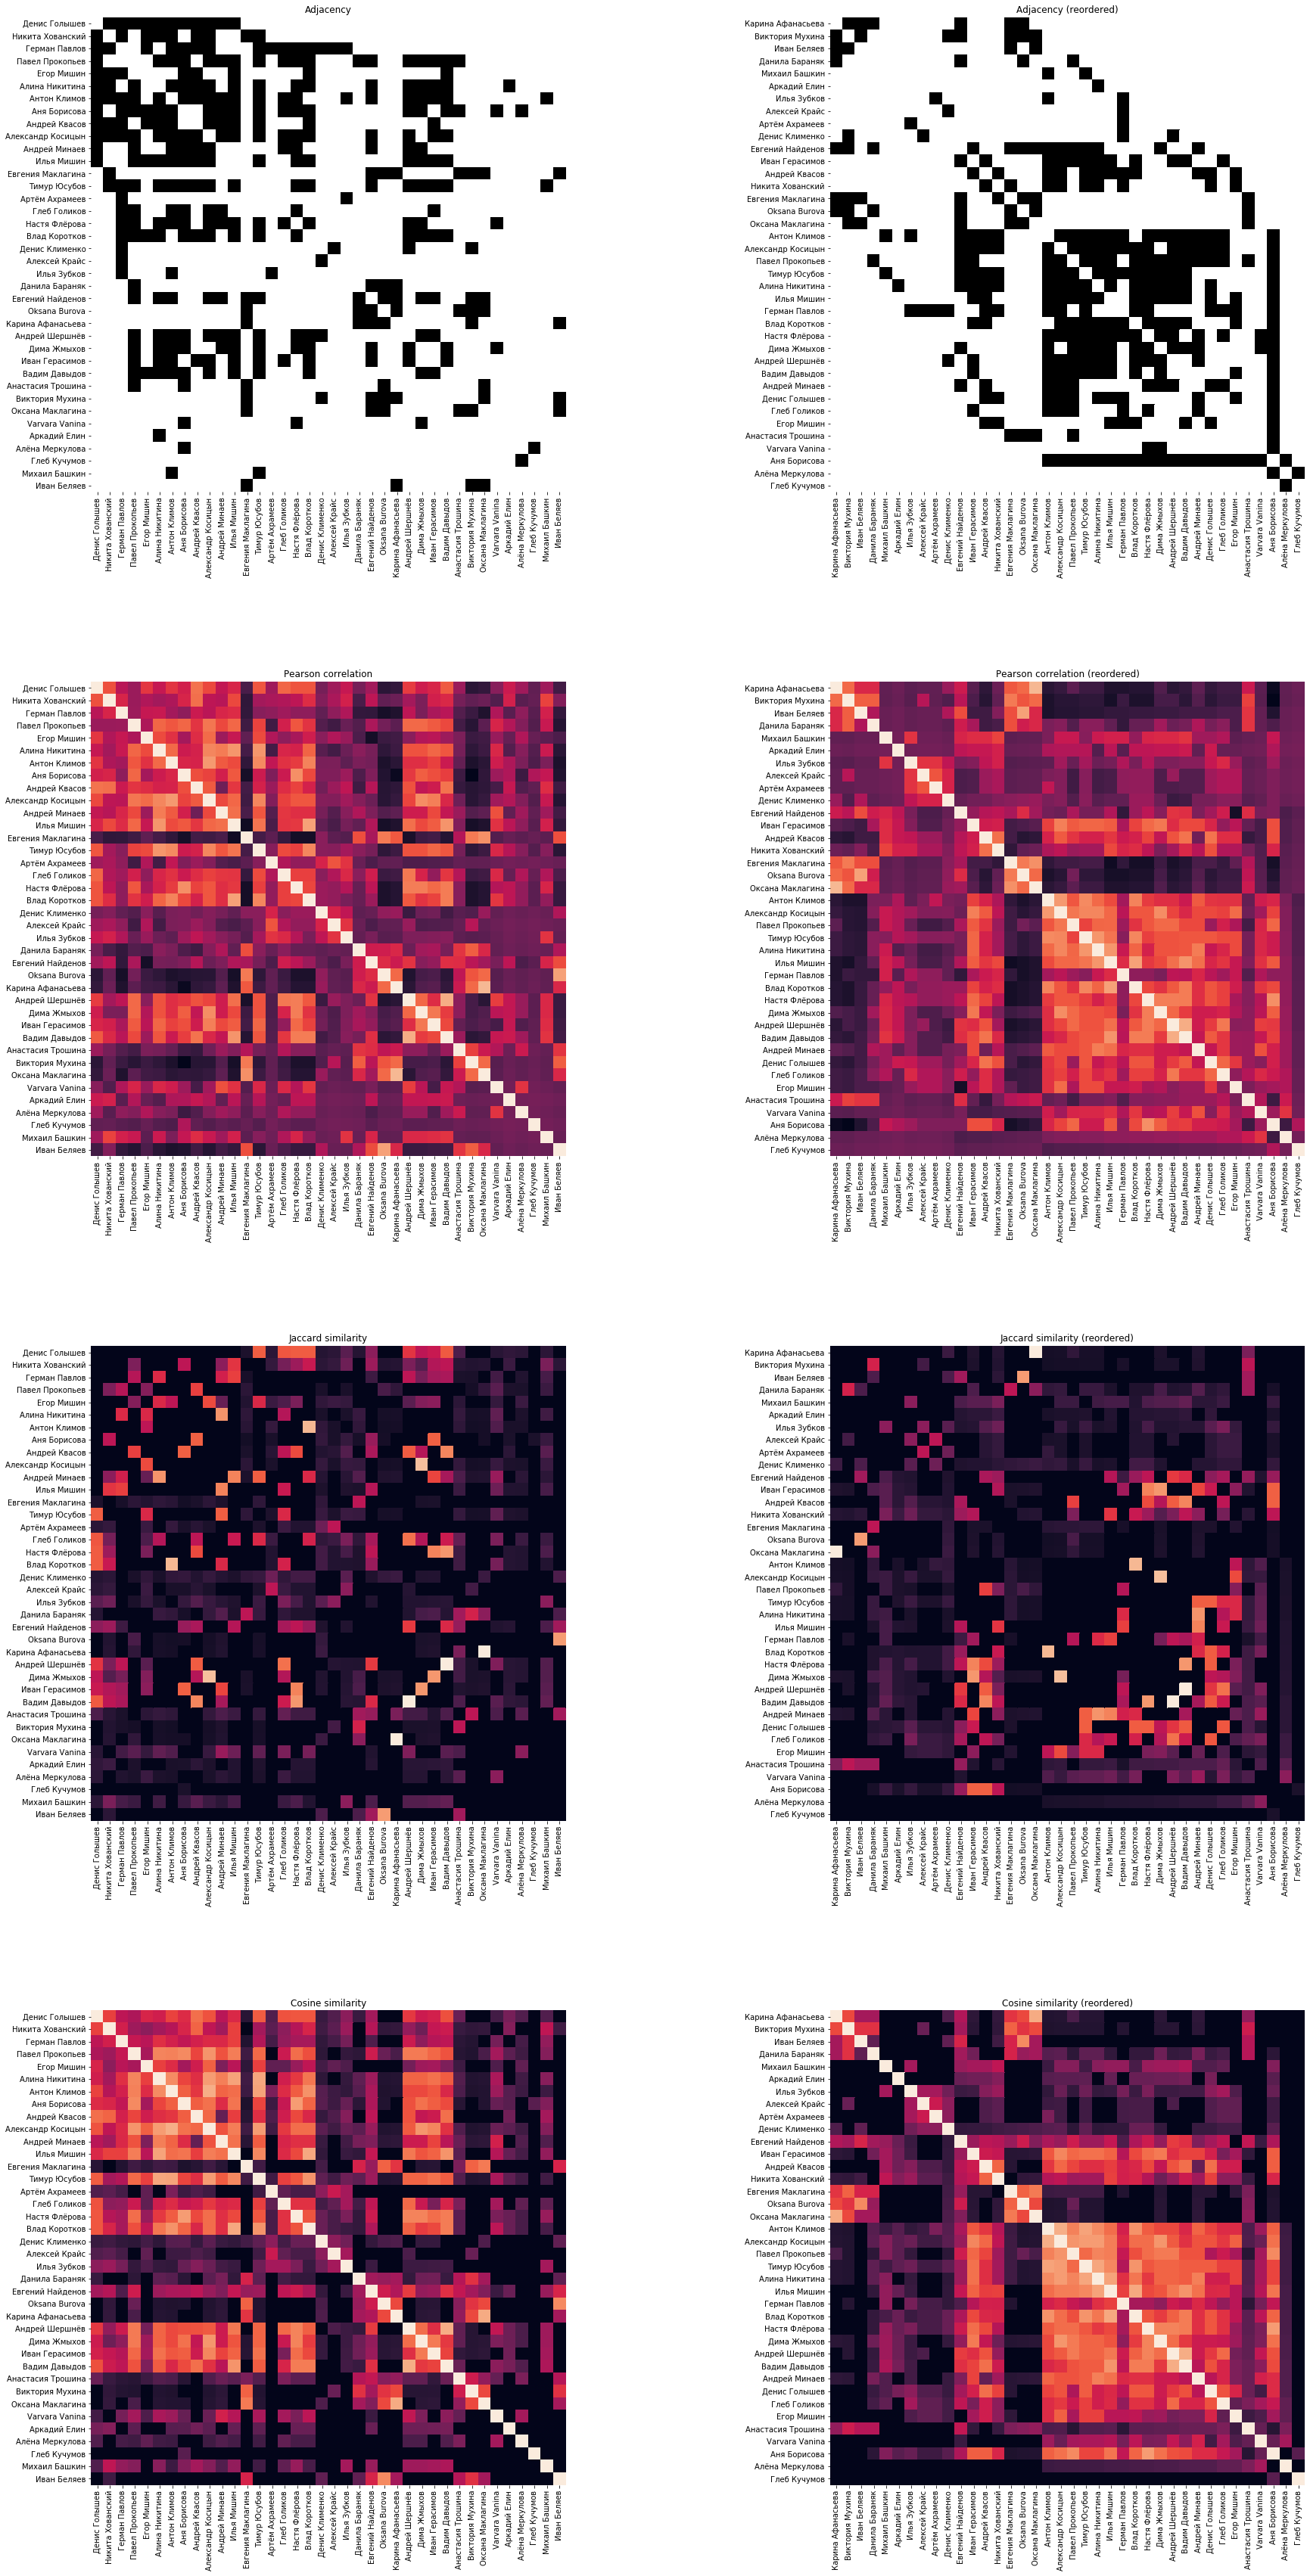

In [220]:
fig = plt.figure(figsize=(30, 30*2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
A, corr, J, cos = sim_matrices(G)
order = cm_order(G)

cases = [[1, A, plt.cm.Greys, 'Adjacency', range(len(G.nodes))],
         [2, A, plt.cm.Greys, 'Adjacency (reordered)', order],
         [3, corr, None, 'Pearson correlation', range(len(G.nodes))], 
         [4, corr, None, 'Pearson correlation (reordered)', order], 
         [5, J, None, 'Jaccard similarity',range(len(G.nodes))], 
         [6, J, None, 'Jaccard similarity (reordered)', order], 
         [7, cos, None, 'Cosine similarity', range(len(G.nodes))], 
         [8, cos, None, 'Cosine similarity (reordered)', order]]

newLabs = np.array([i for i in G.nodes])

for i, matrix, cmap, t, o in cases:
    plt.subplot(4, 2, i)
    hmap = sns.heatmap(
        matrix[np.ix_(o, o)],
        cmap=cmap,
        cbar=False,
        square=True,
        yticklabels=newLabs[o])
    hmap.set_xticklabels(
        labels=newLabs[o], 
        rotation=90)
    plt.title(t)
plt.savefig('simpa.png')

Using information about similarity, we can detect communities with different size. There are big communities, this communities of  friends from schools. This friends connect which other. Moreover, this communities can be dividing by some parts. Also, i can see some little communities. It is community from middle school. This friends have a small connection with big communities, because they prefer to be friends in their own small community and have a small number of connection with friends from big communities. Also, there are communities of friends of my brother from another city.

# Community Detection

Find a maximul clique on the graph

In [60]:
clique = list(nx.find_cliques(G))
clique.sort(key = len, reverse=True)
max_clique = clique[0]
print('Number of people in maximul clique', len(max_clique))

Number of people in maximul clique 9


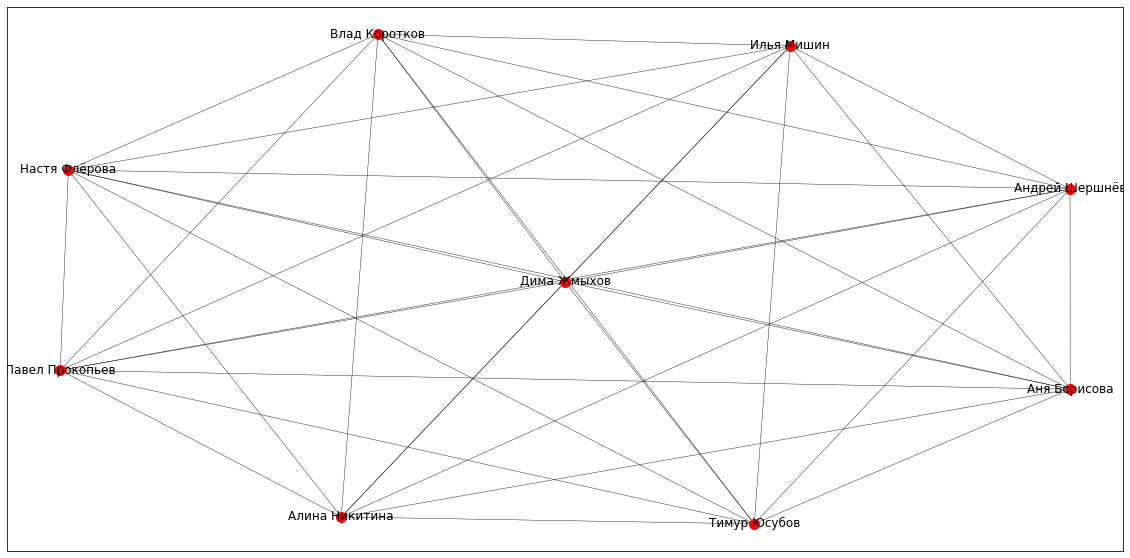

In [61]:
sub_G = nx.subgraph(G, max_clique)
plt.figure(figsize = (20,10))
nx.draw_networkx(sub_G, node_size = 100, width = 0.4, node_color = 'red')
plt.savefig('clique.png')

This clique is friends from my schools. Moreover, this clique contain friends from high schools and friends from parallel class. We was very friendship.

Plot 8-core network.

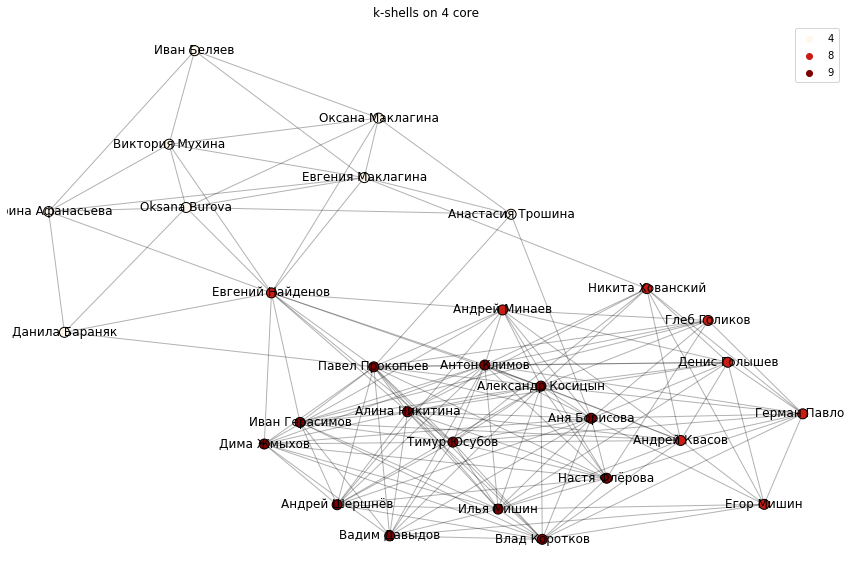

In [62]:
def k_core_decompose(G):
    return np.array([val for _,val in nx.core_number(G).items()])

plt.figure(figsize=(15,10))
sub_G = nx.k_core(G,4)
pos = nx.kamada_kawai_layout(sub_G)
nodes = nx.draw_networkx_nodes(
        sub_G, 
        pos,
        cmap=plt.cm.OrRd,
        node_color=k_core_decompose(sub_G), 
        node_size=100, 
        edgecolors='black',
    )
nx.draw_networkx_labels(
    sub_G,
    pos
)
nx.draw_networkx_edges(
        sub_G, 
        pos,
        alpha=0.3,
        width=1, 
        edge_color='black')
plt.legend(*nodes.legend_elements())
plt.title('k-shells on 4 core')
plt.axis('off')
plt.savefig('k-shells on 4 core.png')

According k-shells on 4 core we can see 2 communities. It is friends from middle school (4 shell) and friends from high schools with another friends from schools (8,9 schools). My best friend from middle school (Евгений Найденов) have a lot some connections with friends from high schools, so he have 8 shell.

# Different communities detection approach.

To detect communities on the ego network i will use Laplacian Eigenmaps, Agglomerative clustering, async update labels. Since, this components contain a few number of nodes (38 friends), i can detect communities from my assumptions and use it to calculate ground truth score.

In [63]:
true_labels = pd.read_csv('myFriends.csv', encoding = "windows-1251", sep=';')
true_labels.head()

,name,labels
0,Денис Голышев,1
1,Никита Хованский,1
2,Герман Павлов,2
3,Павел Прокопьев,3
4,Егор Мишин,1


From my assumptions i detect next communities:
1. Label 1. Friends from my school.
2. Label 2. Friends of my cousin.
3. Label 3. Classmates from high school.
4. Label 4. Friends from another schools.
5. Label 5. Classmates from middle school.

In [64]:
true_labels['labels'].value_counts()/true_labels.shape[0]

5    0.263158
3    0.263158
2    0.184211
4    0.157895
1    0.131579
Name: labels, dtype: float64

In [65]:
true_labels_map = {name : label for name, label in true_labels[['name','labels']].values}

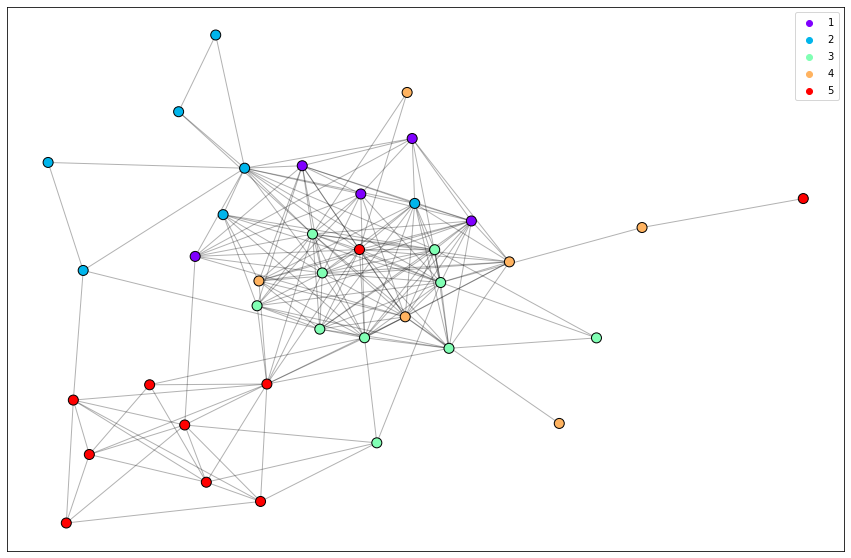

In [66]:
fig = plt.figure(figsize = (15,10))
color = [true_labels_map[node] for node in G.nodes]
pos = nx.kamada_kawai_layout(G)
nodes = nx.draw_networkx_nodes(
        G, 
        pos,
        cmap=plt.cm.rainbow,
        node_color = color, 
        node_size=100, 
        edgecolors='black',
    )
nx.draw_networkx_edges(
        G, 
        pos,
        alpha=0.3,
        width=1, 
        edge_color='black')
plt.legend(*nodes.legend_elements())
plt.savefig('true com.png')

# Laplacian Eigenmaps

In [222]:
def norm_laplacian(A):
    from scipy.linalg import fractional_matrix_power
    deg_seq = A.sum(axis=0)
    D = np.diag(deg_seq)
    L = fractional_matrix_power(D, -1/2)@(D-A)@fractional_matrix_power(D, -1/2)
    return L, deg_seq

def spectral_embedding(L, degree_seq, n_components):
    eig_vec = np.linalg.eigh(L)[1]
    norm_vec = eig_vec * np.power(degree_seq, -0.5)
    return norm_vec[:,1:n_components+1]

def spectral_clustering(G, n_clusters, n_components):
    A = nx.to_numpy_array(G)
    L, degree_seq = norm_laplacian(A)
    embedding = spectral_embedding(L, degree_seq, n_components)
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedding)
    return kmeans.labels_

In [223]:
def silhouette_cluster_score(G, labels):
    A = nx.to_numpy_array(G)
    cos = cosine_similarity(A)
    return silhouette_score(cos, labels)

In [224]:
def ground_truth(G, labels):
    true_labels = [true_labels_map[node] for node in G.nodes]
    return adjusted_rand_score(true_labels, labels)

In [225]:
def comm_from_labels(labels):
    comm = defaultdict(list)
    for ind, l in enumerate(labels):
        comm[l].append(ind)
        
    return [val for _,val in comm.items()]

In [226]:
new_G = G.copy()
new_G = nx.relabel_nodes(new_G,{node : ind for ind, node in enumerate(G.nodes)})
labels = np.array(list(new_G)) # initial partition
res = []
for n_cluster in range(2,11):
    for n_comp in range(2,11):
        labels = spectral_clustering(G, n_cluster, n_comp)
        comm = comm_from_labels(labels)
        mod = nx.community.modularity(new_G, comm)
        silh_score = silhouette_cluster_score(G, labels)
        ground_truth_score = ground_truth(G, labels)
        res.append({'param' : (n_cluster,n_comp), 
                    'modularity' : mod, 
                    'silhouette score' : silh_score,
                   'ground truth score' : ground_truth_score})

res = pd.DataFrame(res)
res

,param,modularity,silhouette score,ground truth score
0,"(2, 2)",0.210942,0.381422,0.125273
1,"(2, 3)",0.210942,0.381422,0.125273
2,"(2, 4)",0.210942,0.381422,0.125273
3,"(2, 5)",0.210942,0.381422,0.125273
4,"(2, 6)",0.210942,0.381422,0.125273
...,...,...,...,...
76,"(10, 6)",0.168934,-0.045633,0.263997
77,"(10, 7)",0.165115,-0.083939,0.306798
78,"(10, 8)",0.165588,-0.058738,0.275909
79,"(10, 9)",0.177140,-0.047004,0.225753


In [227]:
print('Best parameters by modularity', res[res['modularity'] == res['modularity'].max()]['param'].values)
print('Best modularity score', res[res['modularity'] == res['modularity'].max()]['modularity'].values)
print('Best parameters by silhouette score', res[res['silhouette score'] == res['silhouette score'].max()]['param'].values)
print('Best silhouette score', res[res['silhouette score'] == res['silhouette score'].max()]['silhouette score'].values)
print('Best parameters by ground truth score', res[res['ground truth score'] == res['ground truth score'].max()]['param'].values)
print('Best ground truth score', res[res['ground truth score'] == res['ground truth score'].max()]['ground truth score'].values)

Best parameters by modularity [(4, 3)]
Best modularity score [0.25525502]
Best parameters by silhouette score [(2, 2) (2, 3) (2, 4) (2, 5) (2, 6) (2, 7) (2, 8) (2, 9) (2, 10)]
Best silhouette score [0.38142155 0.38142155 0.38142155 0.38142155 0.38142155 0.38142155
 0.38142155 0.38142155 0.38142155]
Best parameters by ground truth score [(8, 5)]
Best ground truth score [0.43362965]


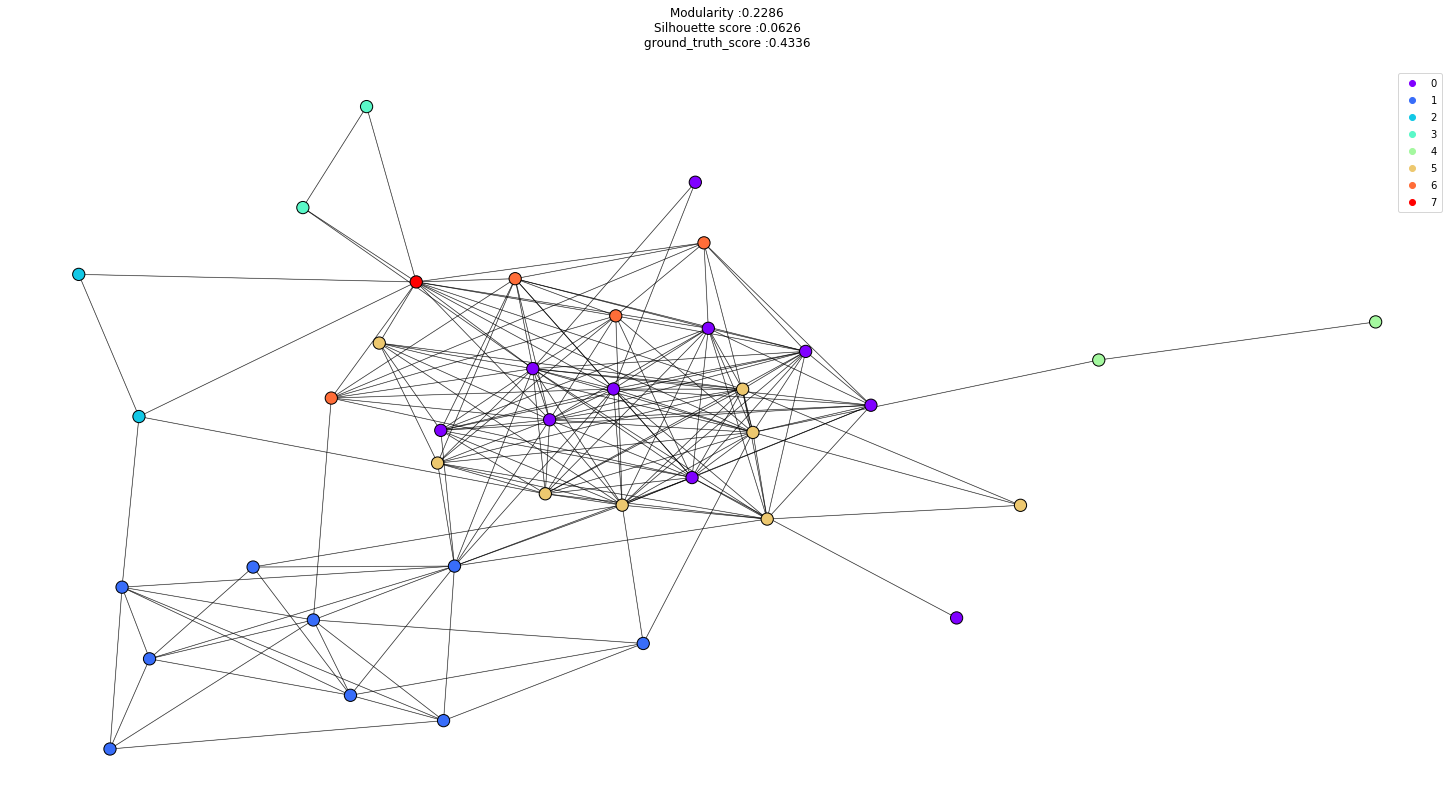

In [231]:
labels = spectral_clustering(G, 8, 5)
comm = comm_from_labels(labels)
mod = nx.community.modularity(new_G, comm)
silh_score = silhouette_cluster_score(G, labels)
ground_truth_score = ground_truth(G, labels)
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(20, 10))
nx.draw_kamada_kawai(
    G, 
    cmap=plt.cm.rainbow,
    node_color=labels, 
    edgecolors='black', 
    node_size=100,
    width = 0.4)

nodes = nx.draw_networkx_nodes(
        G, 
        pos,
        cmap=plt.cm.rainbow,
        node_color = labels, 
        node_size=150, 
        edgecolors='black',
    )
nx.draw_networkx_edges(
        G, 
        pos,
        alpha=0.3,
        width=1, 
        edge_color='black')
plt.legend(*nodes.legend_elements())
plt.title('Modularity :' + str(round(mod,4)) + '\n' +
         'Silhouette score :' + str(round(silh_score,4)) + '\n'+
         'ground_truth_score :' + str(round(ground_truth_score, 4)) + '\n')

plt.savefig('new_laplas.png')

# Agglomerative clustering

In [232]:
def simrank_distance(G):
    sim_rank = nx.simrank_similarity_numpy(G)
    sim_dist = 1 - sim_rank
    sim_dist = 0.5*(sim_dist + sim_dist.T)
    return sim_dist

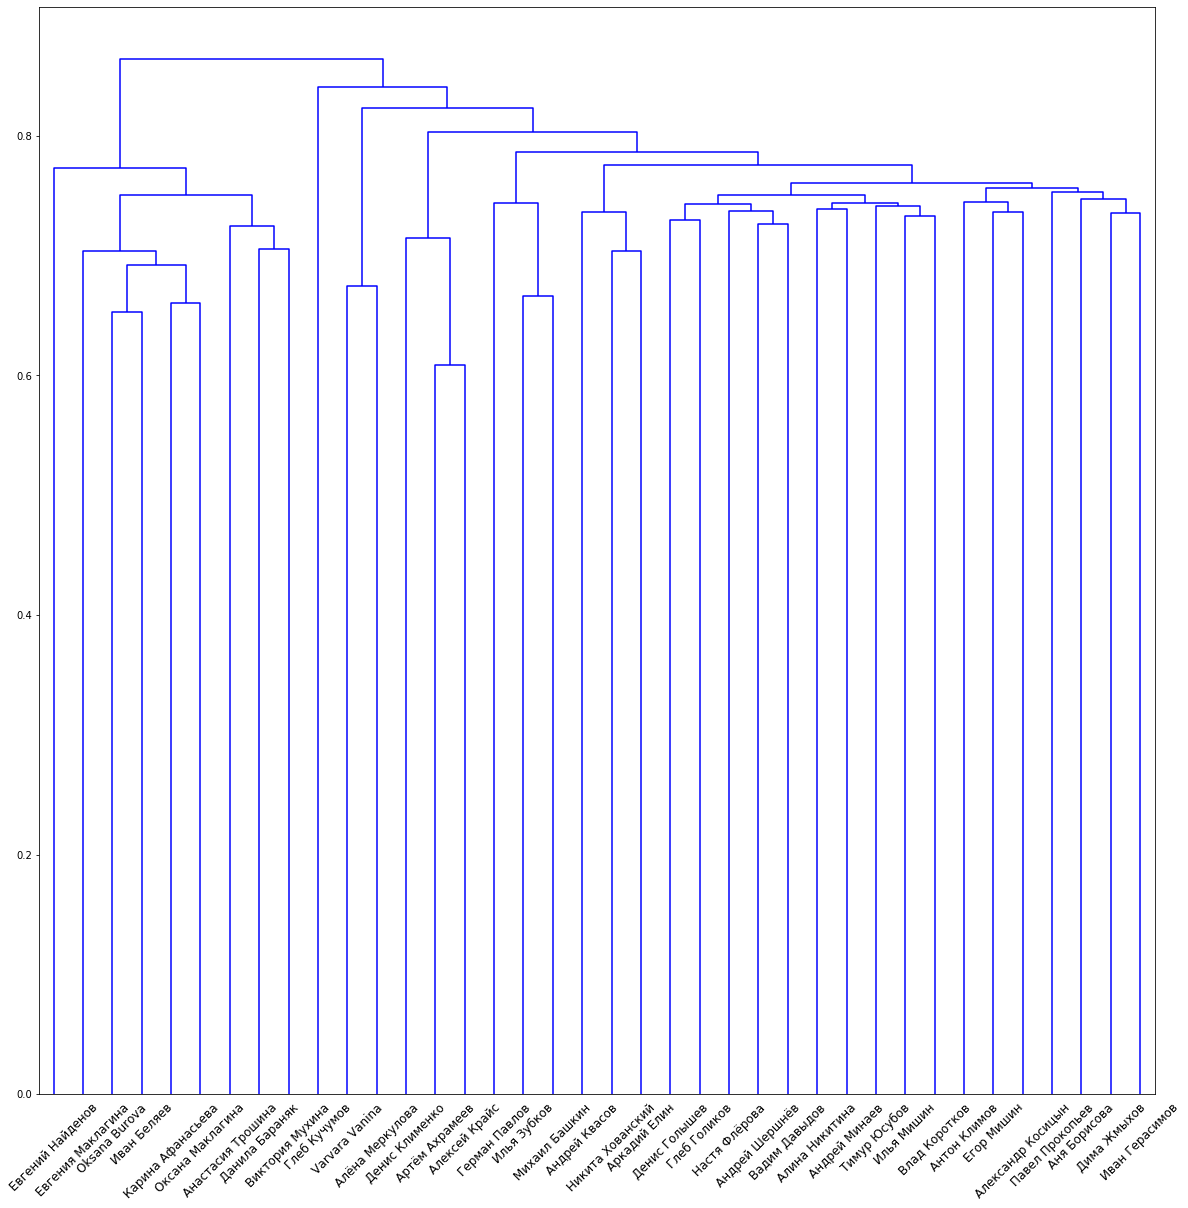

<Figure size 432x288 with 0 Axes>

In [233]:
distance = simrank_distance(G)
plt.figure(figsize=(20, 20))
linked = linkage(squareform(distance), 'complete')
dendrogram(linked, labels=list(G.nodes), 
           leaf_font_size=12)
plt.show()
plt.savefig('dendr.png')

In [234]:
def agglomerative_clustering(distance, max_distance):
    model = AgglomerativeClustering(None, affinity='precomputed',linkage='complete' ,distance_threshold = max_distance)
    model.fit(distance)
    return np.array(model.labels_)

In [235]:
distance = simrank_distance(G)
res = []
for t in np.arange(0.78, 0.85, 0.01):
        labels = agglomerative_clustering(distance, t)
        comm = comm_from_labels(labels)
        mod = nx.community.modularity(new_G, comm)
        silh_score = silhouette_cluster_score(G, labels)
        ground_truth_score = ground_truth(G, labels)
        res.append({'param' : t, 
                    'modularity' : mod, 
                    'silhouette score' : silh_score,
                   'ground truth score' : ground_truth_score})

res = pd.DataFrame(res)
res

,param,modularity,silhouette score,ground truth score
0,0.78,0.221405,0.322866,0.228974
1,0.79,0.217681,0.366525,0.179430
2,0.80,0.217681,0.366525,0.179430
3,0.81,0.210295,0.286583,0.150690
4,0.82,0.210295,0.286583,0.150690
5,0.83,0.209964,0.341372,0.153451
6,0.84,0.209964,0.341372,0.153451


In [236]:
print('Best parameters by modularity', res[res['modularity'] == res['modularity'].max()]['param'].values)
print('Best modularity score', res[res['modularity'] == res['modularity'].max()]['modularity'].values)
print('Best parameters by silhouette score', res[res['silhouette score'] == res['silhouette score'].max()]['param'].values)
print('Best silhouette score', res[res['silhouette score'] == res['silhouette score'].max()]['silhouette score'].values)
print('Best parameters by ground truth score', res[res['ground truth score'] == res['ground truth score'].max()]['param'].values)
print('Best ground truth score', res[res['ground truth score'] == res['ground truth score'].max()]['ground truth score'].values)

Best parameters by modularity [0.78]
Best modularity score [0.22140513]
Best parameters by silhouette score [0.79 0.8 ]
Best silhouette score [0.36652548 0.36652548]
Best parameters by ground truth score [0.78]
Best ground truth score [0.22897399]


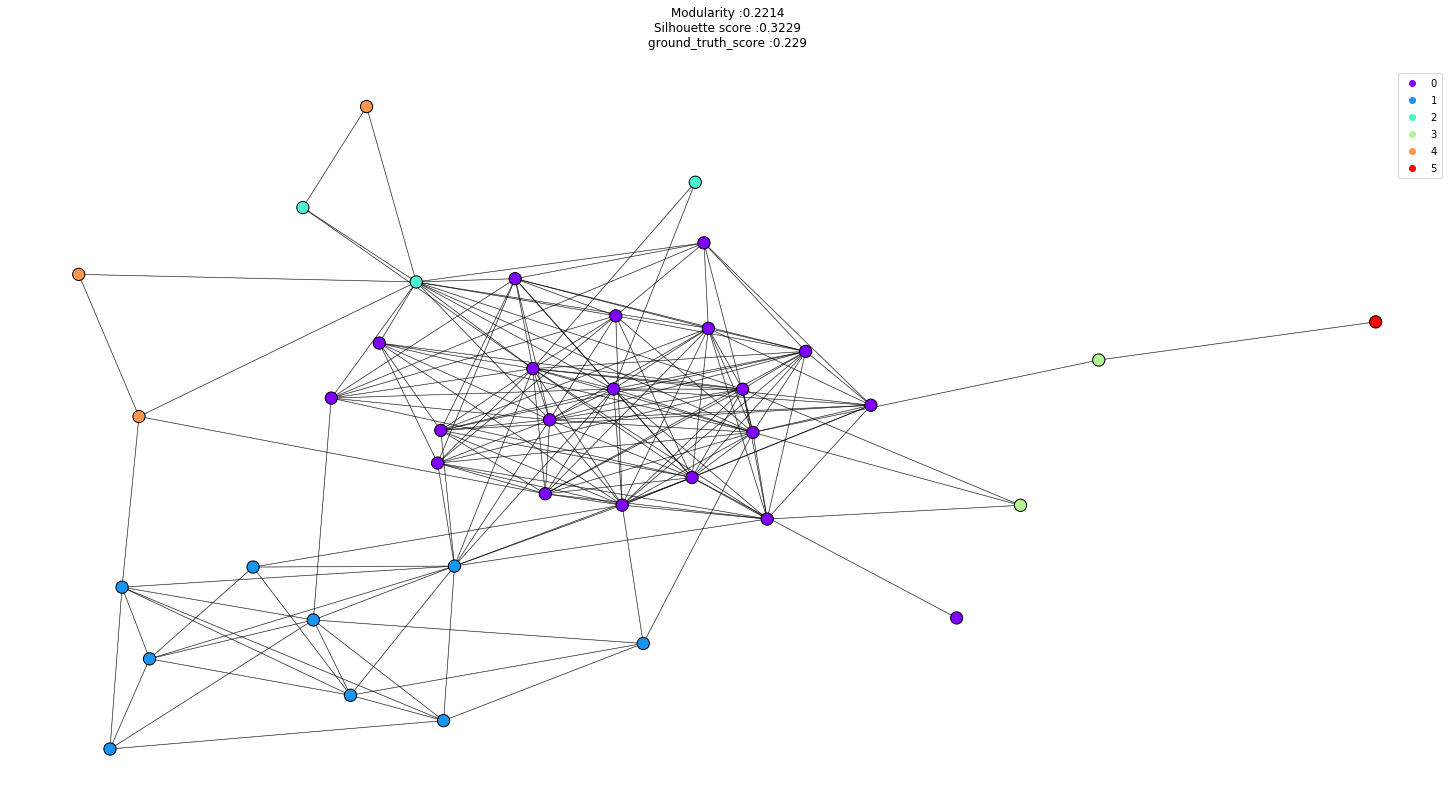

In [241]:
labels = agglomerative_clustering(distance, 0.78)
comm = comm_from_labels(labels)
mod = nx.community.modularity(new_G, comm)
silh_score = silhouette_cluster_score(G, labels)
ground_truth_score = ground_truth(G, labels)

plt.figure(figsize=(20, 10))
nx.draw_kamada_kawai(
    G, 
    cmap=plt.cm.rainbow,
    node_color=labels, 
    edgecolors='black', 
    node_size=100,
    width = 0.4)
pos = nx.kamada_kawai_layout(G)
nodes = nx.draw_networkx_nodes(
        G, 
        pos,
        cmap=plt.cm.rainbow,
        node_color = labels, 
        node_size=150, 
        edgecolors='black',
    )
nx.draw_networkx_edges(
        G, 
        pos,
        alpha=0.3,
        width=1, 
        edge_color='black')
plt.legend(*nodes.legend_elements())
plt.title('Modularity :' + str(round(mod,4)) + '\n' +
         'Silhouette score :' + str(round(silh_score,4)) + '\n'+
         'ground_truth_score :' + str(round(ground_truth_score, 4)) + '\n')
plt.savefig('aglam.png')

# async update labels

In [242]:
def async_update_labels(graph, labels):
    new_labels = labels.copy()
    nodes = list(graph.nodes)
    np.random.shuffle(nodes)
    for node in nodes:
        neib = list(nx.neighbors(graph, node))
        most_label = Counter(new_labels[neib]).most_common(1)[0][0]
        new_labels[node] = most_label
    
    return new_labels

In [243]:
res = []
labels = np.array(list(range(len(G.nodes))))
for t in np.arange(2, 10, 1):
        labels = async_update_labels(new_G, labels)
        comm = comm_from_labels(labels)
        mod = nx.community.modularity(new_G, comm)
        silh_score = silhouette_cluster_score(G, labels)
        ground_truth_score = ground_truth(G, labels)
        res.append({'param' : t, 
                    'modularity' : mod, 
                    'silhouette score' : silh_score,
                   'ground truth score' : ground_truth_score})

res = pd.DataFrame(res)
res

,param,modularity,silhouette score,ground truth score
0,2,0.139487,0.131785,0.115363
1,3,0.149902,0.336958,0.056712
2,4,0.150597,0.374546,0.041387
3,5,0.150597,0.374546,0.041387
4,6,0.150597,0.374546,0.041387
5,7,0.150597,0.374546,0.041387
6,8,0.150597,0.374546,0.041387
7,9,0.150597,0.374546,0.041387


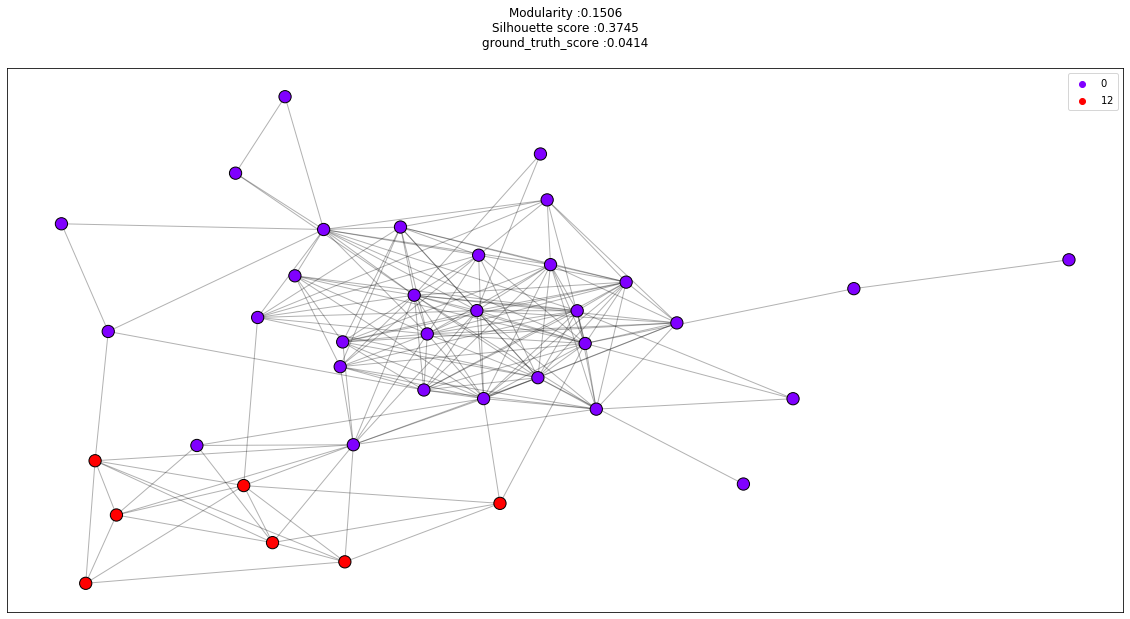

In [244]:
comm = comm_from_labels(labels)
mod = nx.community.modularity(new_G, comm)
silh_score = silhouette_cluster_score(G, labels)
ground_truth_score = ground_truth(G, labels)

plt.figure(figsize=(20, 10))
pos = nx.kamada_kawai_layout(new_G)

nodes = nx.draw_networkx_nodes(
        new_G, 
        pos,
        cmap=plt.cm.rainbow,
        node_color = labels, 
        node_size=150, 
        edgecolors='black',
    )
nx.draw_networkx_edges(
        new_G, 
        pos,
        alpha=0.3,
        width=1, 
        edge_color='black')
plt.legend(*nodes.legend_elements())
plt.title('Modularity :' + str(round(mod,4)) + '\n' +
         'Silhouette score :' + str(round(silh_score,4)) + '\n'+
         'ground_truth_score :' + str(round(ground_truth_score, 4)) + '\n')
plt.savefig('async.png')